# Data Preparation

### Importing standard libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jb

### Load the dataset

In [5]:
#1. Getting the kaggle dataset
kaggle_df=pd.read_csv(Path.cwd().parent/'data/interim/kaggle/raw_kaggle_churn_data.csv')
#2. Getting the gdrive dataset
gdrive_df=pd.read_csv(Path.cwd().parent/'data/interim/gdrive/raw_gdrive_churn_data.csv')

### Combining the datasets into single dataframe

In [6]:
combined_raw_df=pd.concat([kaggle_df,gdrive_df],axis=0)

### Inspect Dataset

#### * Dataset Shape

In [7]:
print("Dataset Shape:",combined_raw_df.shape)

Dataset Shape: (5630, 22)


#### * Checking data types and missing values

In [8]:
combined_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5630 entries, 0 to 2814
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress        

In [9]:
# Missing values per column
print("\nMissing values per column:\n",combined_raw_df.isnull().sum())


Missing values per column:
 CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
source                           0
data_last_updated_dt             0
dtype: int64


### Handling Missing Values

#### Filling missing numeric values

In [10]:
#filling missing numeric values
combined_raw_df.fillna(combined_raw_df.median(numeric_only=True),inplace=True)

#### Filling missing categorical values

In [11]:
#filling missing categorical values
combined_raw_df.fillna(combined_raw_df.mode().iloc[0],inplace=True)

In [12]:
#Validating for the missing values
combined_raw_df.isnull().sum()

CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
source                         0
data_last_updated_dt           0
dtype: int64

#### Convert Data Types

In [13]:
#Convert 'data_last_updated_dt' to datetime format
combined_raw_df['data_last_updated_dt']=pd.to_datetime(combined_raw_df['data_last_updated_dt'],errors='coerce')

### Encoding Categorical Variables

In [14]:
categorical_columns = ["PreferredLoginDevice", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus", "source"] # These are the categorical columns in our data
encoder = LabelEncoder()
for col in categorical_columns:
    combined_raw_df[col] = encoder.fit_transform(combined_raw_df[col])

### Feature Scaling

In [15]:
scaler=StandardScaler()
numerical_columns = ["Tenure", "WarehouseToHome", "HourSpendOnApp", "OrderAmountHikeFromlastYear", "CouponUsed", "OrderCount", "DaySinceLastOrder", "CashbackAmount"]
combined_raw_df[numerical_columns] = scaler.fit_transform(combined_raw_df[numerical_columns])

In [16]:
#ByteStreaming the scaler
jb.dump(scaler,Path.cwd().parent/'models/scaler.joblib')

['c:\\Users\\asus\\Documents\\Projects\\ECommerce Customer Churn Prediction\\models\\scaler.joblib']

### Handle Data Features

In [100]:
combined_raw_df['data_last_updated_year'] = combined_raw_df['data_last_updated_dt'].dt.year
combined_raw_df.drop(columns=['data_last_updated_dt'], inplace=True)  # Remove original date column

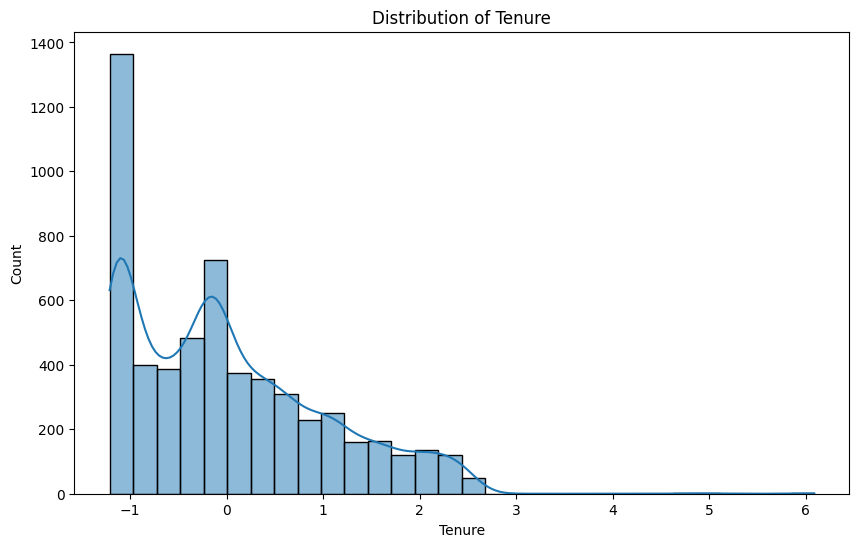

In [101]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.histplot(combined_raw_df["Tenure"], bins=30, kde=True)
plt.title("Distribution of Tenure")
plt.show()

Highly Correlated Features (above threshold of 0.8):
     Feature 1       Feature 2  Correlation
0  OrderCount      CouponUsed     0.641178
1      source      CustomerID    -0.866025
2      source  HourSpendOnApp    -0.664691


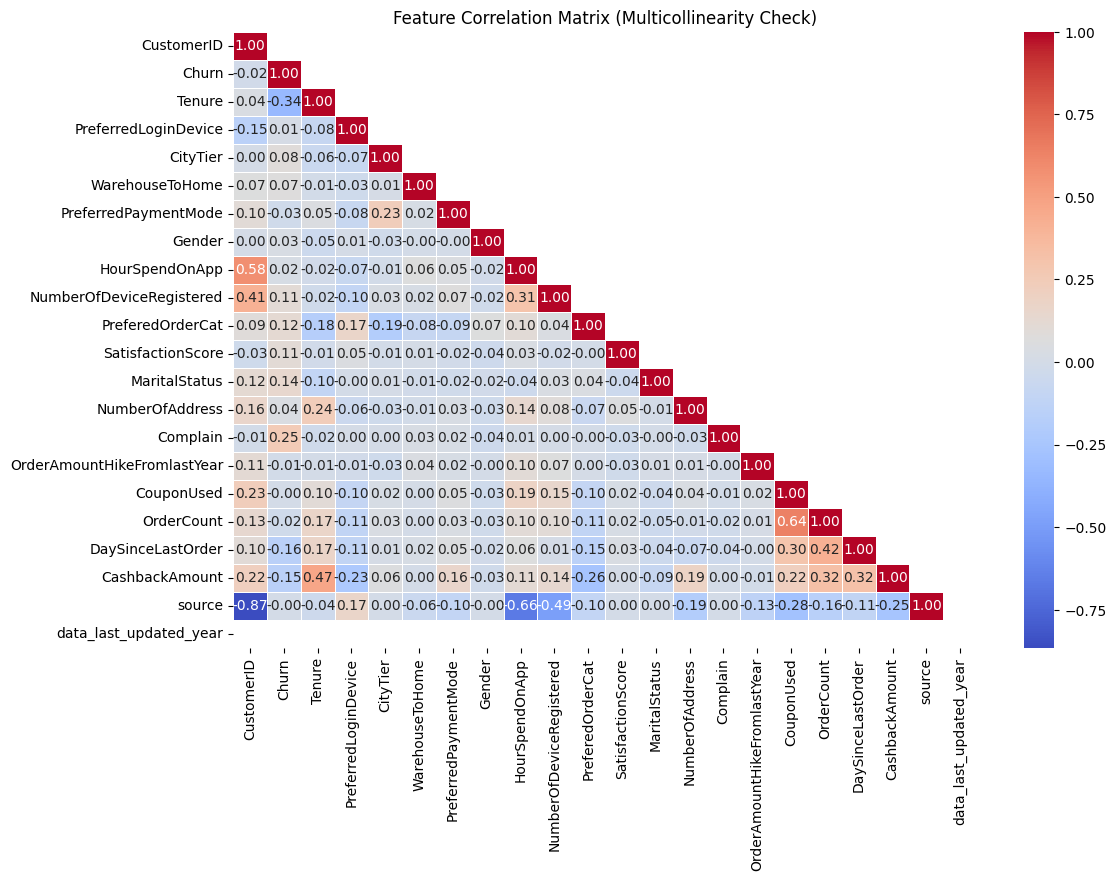

In [102]:
# Find highly correlated features (multicollinearity check)
correlation_matrix = combined_raw_df.corr()
threshold = 0.6  # Set threshold for high correlation

# Identify pairs of highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convert to DataFrame for better readability
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
print("Highly Correlated Features (above threshold of 0.8):\n", high_corr_df)

# Visualizing the correlation matrix with a focus on high correlation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, mask=np.triu(correlation_matrix, k=1))
plt.title("Feature Correlation Matrix (Multicollinearity Check)")
plt.show()


* We saw above the pairs of features which are having high-collinearity when setting threshold to 60%. 
* We can drop source as that is a custom column and anyway won't be getting it as input in production.
* We can also remove CouponUsed and keep OrderCount instead.

Correlation of features with Churn:
 Churn                          1.000000
Complain                       0.250188
MaritalStatus                  0.140316
PreferedOrderCat               0.118922
NumberOfDeviceRegistered       0.107939
SatisfactionScore              0.105481
CityTier                       0.084703
WarehouseToHome                0.069544
NumberOfAddress                0.043931
Gender                         0.029264
HourSpendOnApp                 0.018816
PreferredLoginDevice           0.013281
OrderAmountHikeFromlastYear   -0.007075
CustomerID                    -0.019083
OrderCount                    -0.024038
PreferredPaymentMode          -0.026519
CashbackAmount                -0.154118
DaySinceLastOrder             -0.155871
Tenure                        -0.337831
data_last_updated_year              NaN
Name: Churn, dtype: float64


C:\Users\asus\AppData\Local\Temp\ipykernel_37384\4280969273.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_corr.index, y=churn_corr.values, palette="coolwarm")


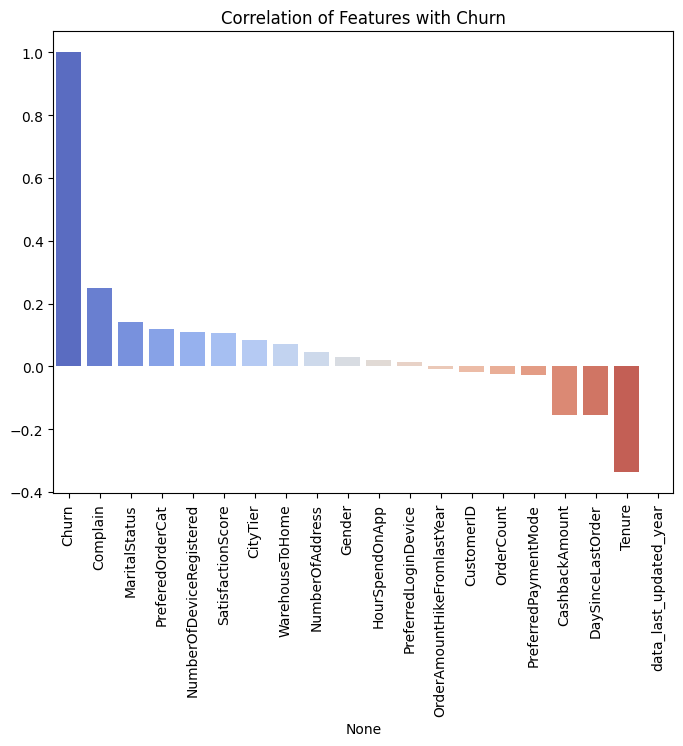

In [103]:
# Dropping one column out of each highly correlated column pairs we saw above:
high_corr_cols=[
    'source',
    'CouponUsed'
]
df_wo_multicollinearity=combined_raw_df.drop(high_corr_cols,axis=1)

# Correlation with Churn Column
churn_corr = df_wo_multicollinearity.corr()["Churn"].sort_values(ascending=False)
print("Correlation of features with Churn:\n", churn_corr)

# Visualizing correlation with Churn
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_corr.index, y=churn_corr.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Correlation of Features with Churn")
plt.show()


In [104]:
# Keep Only Features Correlated with Churn (> 0.15)
corr_with_churn = df_wo_multicollinearity.corr()["Churn"].abs()
selected_features = corr_with_churn[corr_with_churn >= 0.10].index.tolist()
selected_features.append("CustomerID")
df_wo_multicollinearity = df_wo_multicollinearity[selected_features]
df_wo_multicollinearity.head(5)

,Churn,Tenure,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,Complain,DaySinceLastOrder,CashbackAmount,CustomerID
0,1,-0.733989,3,2,2,2,1,0.151436,-0.351465,50001
1,1,-0.135704,4,3,3,2,1,-1.249003,-1.144715,50002
2,1,-0.135704,4,3,3,2,1,-0.408739,-1.157316,50003
3,1,-1.212618,4,2,5,2,0,-0.408739,-0.877047,50004
4,1,-1.212618,3,3,5,2,0,-0.408739,-0.967895,50005


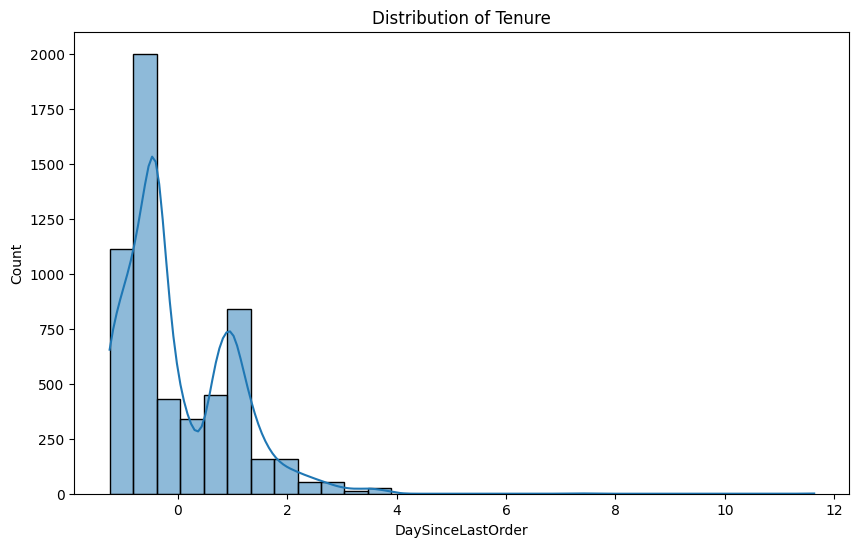

In [105]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.histplot(df_wo_multicollinearity["DaySinceLastOrder"], bins=30, kde=True)
plt.title("Distribution of Tenure")
plt.show()

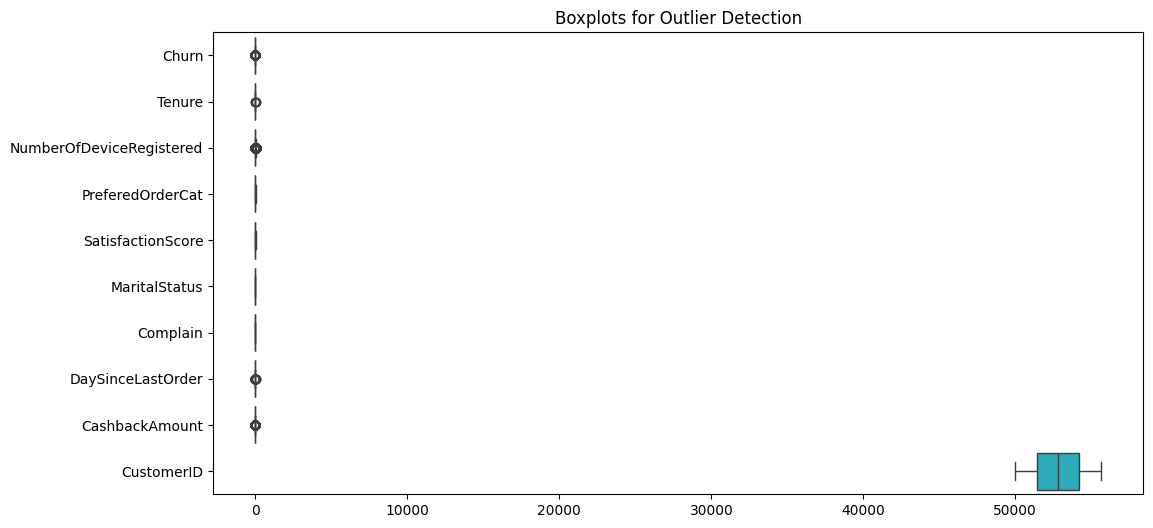

In [106]:
# Outlier Detection using Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_wo_multicollinearity, orient="h")
plt.title("Boxplots for Outlier Detection")
plt.show()

* No Outlier found

### Final Check

In [107]:
display(df_wo_multicollinearity.head())
df_wo_multicollinearity.info()

,Churn,Tenure,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,Complain,DaySinceLastOrder,CashbackAmount,CustomerID
0,1,-0.733989,3,2,2,2,1,0.151436,-0.351465,50001
1,1,-0.135704,4,3,3,2,1,-1.249003,-1.144715,50002
2,1,-0.135704,4,3,3,2,1,-0.408739,-1.157316,50003
3,1,-1.212618,4,2,5,2,0,-0.408739,-0.877047,50004
4,1,-1.212618,3,3,5,2,0,-0.408739,-0.967895,50005


<class 'pandas.core.frame.DataFrame'>
Index: 5630 entries, 0 to 2814
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Churn                     5630 non-null   int64  
 1   Tenure                    5630 non-null   float64
 2   NumberOfDeviceRegistered  5630 non-null   int64  
 3   PreferedOrderCat          5630 non-null   int32  
 4   SatisfactionScore         5630 non-null   int64  
 5   MaritalStatus             5630 non-null   int32  
 6   Complain                  5630 non-null   int64  
 7   DaySinceLastOrder         5630 non-null   float64
 8   CashbackAmount            5630 non-null   float64
 9   CustomerID                5630 non-null   int64  
dtypes: float64(3), int32(2), int64(5)
memory usage: 439.8 KB


### Saved the clean dataset

In [109]:
df_wo_multicollinearity.to_csv(Path().cwd().parent/"data/processed/churn_data_prepared.csv",index=False)
print("Data Preparation Completed and Saved as 'churn_data_prepared.csv'")

Data Preparation Completed and Saved as 'churn_data_prepared.csv'
